## target
task : img classification

data : CIFAR10

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Hyper parameters
EPOCH = 1
BATCH_SIZE = 100
LR = 0.01
DOWNLOAD_CIFAR10 = False # 請求下載

In [3]:
### load cifar image

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=DOWNLOAD_CIFAR10, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=DOWNLOAD_CIFAR10, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [15]:
type(trainloader.dataset.train_data)

numpy.ndarray

In [4]:
trainset.train_data.shape

(50000, 32, 32, 3)

 ship  frog  bird   cat


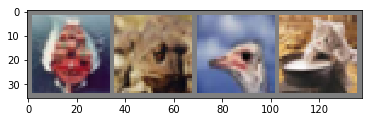

Process Process-2:
  File "/home/team106/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/team106/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/team106/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/team106/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/team106/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/team106/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/team106/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with se

In [5]:
### show some img data

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

## build CNN

In [6]:
class CNN(nn.Module):
    def __init__(self, n_conv1_filter, n_conv2_filter):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(# input size(3, 32, 32)
            nn.Conv2d( 
                in_channels = 3, # RGB
                out_channels = n_conv1_filter, # num_filter
                kernel_size=5, # filter's height and width = 5
                stride=1, # shift 1 distance each time
                padding=2, # if stride=1, padding=(kernel_size-1)/2, filled with zero
            ),# -->(16, 32, 32)
            nn.ReLU(),# -->(16, 32, 32)
            nn.MaxPool2d(kernel_size=2,),# -->(16, 16, 16)
        )
        self.conv2 = nn.Sequential(# input size(16, 16, 16)
            nn.Conv2d(n_conv1_filter, n_conv2_filter, 5, 1, 2), #(in, out, kernel, strid, padding) # -->(32, 16, 16)
            nn.ReLU(),# -->(32, 16, 16)
            nn.MaxPool2d(2), # -->(32, 8, 8)
        )
        self.out = nn.Linear(n_conv2_filter * 8 * 8 , 10) # 10 class
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x) # (batch, 32, 7, 7)
        x = x.view(x.size(0), -1) #(batch, 32*7*7)
        output = self.out(x)
        return output

In [7]:
result = {}

result['param_num'] = []
result['train_acc'] = []
result['test_acc'] = []
result['train_loss'] = []
result['test_loss'] = []

In [16]:
# training and validate 20 different model

for itr in range(1, 21, 1):

    num_filter = itr * 2 + 4
    
    # declare CNN model with num_filter
    cnn=CNN(n_conv1_filter = num_filter, n_conv2_filter = (num_filter*2))
#     print(cnn)

    # count parameters number
    param_num = 0

    for parameter in cnn.parameters(): # find each layer's parameter tensor
        param_each_layer = 1
        for dim in list(parameter.size()): # calculate parameter number
            param_each_layer *=dim

        param_num += param_each_layer # sum

    print('itr %d | param_num %d'% (itr, param_num)) # finally get number of parameters
    
    def training():
        optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
        loss_func = nn.CrossEntropyLoss()

        for epoch in range(EPOCH):
            for step, (x, y) in enumerate(trainloader):
#                 print(type(x),' | ' , type(y))
                b_x = Variable(x, requires_grad=True) # batch x
                b_y = Variable(y) # batch y

                output = cnn(b_x)
                loss = loss_func(output, b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

#         ### train
#         # train_loss
#         train_loss = loss.data[0]
#         # train_acc
#         train_x = Variable(torch.from_numpy(trainloader.dataset.train_data))
#         train_prediction = cnn.forward(train_x)
#         train_pred = torch.max(train_prediction, 1)[1].data.squeeze()
#         train_y = train_data.train_labels
#         train_acc = sum(train_pred ==train_y)/ train_y.size(0)

#         ### test
#         test_pred = cnn.forward(test_x)

#         # test_loss
#         test_loss = loss_func(test_pred, Variable(test_y)).data[0]
#         # test_acc
#         test_pred = torch.max(test_pred, 1)[1].data.squeeze()
#         test_acc = sum(test_pred ==test_y)/ test_y.size(0)
        
        
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            outputs = net(Variable(images))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()

        print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))
    
        
        ### record
        result['param_num'].append(round(param_num, 4))
        result['train_acc'].append(round(train_acc, 4))
        result['test_acc'].append(round(test_acc, 4))
        result['train_loss'].append(round(train_loss, 4))
        result['test_loss'].append(round(test_loss, 4))
        
        ### print
        print(
            'train_acc : %.4f' % train_acc,
            '\t test_acc : %.4f' % test_acc,
            '\t train_loss : %.4f' % train_loss,
            '\t test_loss : %.4f' % test_loss,
        )
        
#         del cnn
        
    training()

itr 1 | param_num 9958


NameError: name 'net' is not defined